This script is to read DSM2 hdf5 output directly and load it into pandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py

## Step 1
Reading in the hdf5 file and table output/channel avg concentration into a pandas frame. 
This is a multi-dimensional table so hierarchical indices are needed to accomodate it. 
The attributes for the table contain the start time and time interval and those are used for indexing the first dimension as a datetime

In [237]:
def read_table_as_array(file_path, table_path, dtype=str):
    '''
    reads table from h5 file_path from the table_path and returns array of dtype
    '''
    with h5py.File(file_path,'r') as f:
        return np.array(f[table_path]).astype(dtype)
def read_dsm2_table(file_path, table_path, column_values, column_names, start_time_key='start_time', interval_key='interval'):
    '''
    file_path: Name of h5 file (full path or relative path)
    table_path: Path within the h5 file to the values table e.g. /output/channel_concentrations
    column_values: Values used for the 2nd and 3rd dimension of table. 
        For DSM2 the 2nd dimension is the variable dimension (flow, stage, constituent)
                 the 3rd dimension is the location dimension (channel, reservoir)
                 Time is always assumed to be the first dimension in the table
    column_names: Names for the 2nd and 3rd dimensions
    '''
    with h5py.File(file_path,'r') as f:
        v=f[table_path]
        a=v.attrs
        start_time=a[start_time_key].astype(str)[0]
        interval=a[interval_key].astype(str)[0]
        vals=np.array(v)
    c1=column_values[0]
    c2=column_values[1]
    x1=c1.repeat(c2.size)
    x2=c2.repeat(c1.size)
    vi=pd.MultiIndex.from_arrays([x1,x2],names=tuple(column_names))
    vti=pd.DatetimeIndex(data=pd.date_range(start=start_time,freq=interval,periods=vals.shape[0])
            ,name="Time")
    return pd.DataFrame(data=vals.reshape(vals.shape[0],vals.shape[1]*vals.shape[2]),index=vti,columns=vi)
def generate_godin_fir(timeinterval='1hour'):
    '''
    generate godin filter impulse response for given timeinterval
    '''
    mins=pd.Timedelta(timeinterval).seconds/60 # FIXME: needs mins_in_interval function
    wts24=np.zeros(round(24*60/mins))
    wts24[:]=1/wts24.size
    tidal_period=round(24.75*60/mins)
    if tidal_period%2==0: tidal_period=tidal_period+1
    wts25=np.zeros(tidal_period)
    wts25[:]=1.0/wts25.size
    return np.convolve(wts25,np.convolve(wts24,wts24))
def godin_filter(df,timeinterval='15min'):
    '''
    return godin filtered values for data frame values
    '''
    godin_ir=generate_godin_fir(timeinterval)
    dfg=pd.DataFrame(np.convolve(df.values,godin_ir,mode='same'))
    dfg.index=df.index
    return dfg

In [234]:
filename='historical_v82_ec.h5'
na1=read_table_as_array(filename,'output/constituent_names')
na2=read_table_as_array(filename, 'output/channel_number',dtype=int)
#print(na1,na2)
df2=read_dsm2_table(filename,'output/channel avg concentration',[na1,na2],['constituent','channel'])
display(df2)

constituent                   ec                                         \
channel                      1            2            3            4     
Time                                                                      
1990-01-04 00:00:00     0.000000     0.000000     0.000000     0.000000   
1990-01-04 01:00:00     3.085389     0.000000     1.135225     0.000000   
1990-01-04 02:00:00     6.242197     0.000002     2.237056     0.024136   
1990-01-04 03:00:00    23.549067     0.025019     2.785858     0.388422   
1990-01-04 04:00:00   130.155472     0.697410     2.864413     1.057938   
1990-01-04 05:00:00   334.666260     3.024008     2.870454     1.788486   
1990-01-04 06:00:00   576.725891     8.412315     2.921257     2.406320   
1990-01-04 07:00:00   806.744751    38.112865     3.487941     2.739224   
1990-01-04 08:00:00   972.615479   142.688263     5.611664     2.867678   
1990-01-04 09:00:00  1056.220459   339.870544    11.739096     3.121627   
1990-01-04 10:00:00  1085.873535   585.420898    38.742168     4.046522   
1990-01-04 11:00:00  1093.645020   810.455566   131.155106     6.778445   
1990-01-04 12:00:00  1095.236084   966.026001   320.394836    16.691652   
1990-01-04 13:00:00  1095.504028  1047.669922   568.230042    48.181950   
1990-01-04 14:00:00  1095.542725  1080.896729   795.778748   120.405983   
1990-01-04 15:00:00  1095.547729  1091.762085   955.454895   251.130310   
1990-01-04 16:00:00  1095.548462  1094.714722  1042.487549   435.883362   
1990-01-04 17:00:00  1095.548706  1095.389771  1079.355469   641.267334   
1990-01-04 18:00:00  1095.548950  1095.521729  1091.763062   827.124390   
1990-01-04 19:00:00  1095.549194  1095.544434  1095.152954   962.597351   
1990-01-04 20:00:00  1095.549438  1095.547974  1095.919800  1040.864990   
1990-01-04 21:00:00  1095.549438  1095.548706  1096.067383  1077.112549   
1990-01-04 22:00:00  1095.549438  1095.548950  1096.092773  1090.448853   
1990-01-04 23:00:00  1095.549316  1095.549194  1096.096680  1094.461304   
1990-01-05 00:00:00  1095.549194  1095.549316  1096.096924  1095.651245   
1990-01-05 01:00:00  1095.506714  1095.549438  1096.082153  1095.979614   
1990-01-05 02:00:00  1095.457031  1095.549438  1096.067017  1096.068848   
1990-01-05 03:00:00  1095.719238  1095.549072  1096.059448  1096.086792   
1990-01-05 04:00:00  1097.888672  1095.539917  1096.058716  1096.082642   
1990-01-05 05:00:00  1102.070679  1095.506470  1096.058105  1096.073730   
...                          ...          ...          ...          ...   
2016-09-28 19:00:00   544.062683   544.069336   544.484497   542.515015   
2016-09-28 20:00:00   544.062683   544.066467   544.425049   542.977600   
2016-09-28 21:00:00   544.062683   544.064209   544.329773   543.584473   
2016-09-28 22:00:00   544.062683   544.063171   544.241394   544.061279   
2016-09-28 23:00:00   544.062683   544.062744   544.172180   544.373230   
2016-09-29 00:00:00   544.062744   544.062622   544.127441   544.525757   
2016-09-29 01:00:00   544.056213   544.062622   544.098816   544.572266   
2016-09-29 02:00:00   544.049011   544.062683   544.083191   544.555054   
2016-09-29 03:00:00   544.042053   544.062683   544.076172   544.533264   
2016-09-29 04:00:00   544.060974   544.062683   544.071716   544.515015   
2016-09-29 05:00:00   544.326843   544.062561   544.069214   544.501099   
2016-09-29 06:00:00   545.305786   544.061707   544.067810   544.489502   
2016-09-29 07:00:00   547.255371   544.059753   544.066650   544.481689   
2016-09-29 08:00:00   549.994263   544.056763   544.064758   544.451782   
2016-09-29 09:00:00   553.302124   544.055542   544.063477   544.400574   
2016-09-29 10:00:00   556.915344   544.080200   544.062866   544.333435   
2016-09-29 11:00:00   560.575623   544.229248   544.062683   544.264954   
2016-09-29 12:00:00   563.946472   544.713318   544.062500   544.205261   
2016-09-29 13:00:00   566.683899   545.773804   544.061829   544.158020   
2016-09-29 14:00:00   568

In [238]:
df2g=godin_filter(df2['ec'][441])
display(df2['ec'][441])
#display(df2g)


,0
Time,
1990-01-04 00:00:00,9843.771747
1990-01-04 01:00:00,10008.548636
1990-01-04 02:00:00,10173.624577
1990-01-04 03:00:00,10338.960053
1990-01-04 04:00:00,10504.517414
1990-01-04 05:00:00,10670.257545
1990-01-04 06:00:00,10836.139628
1990-01-04 07:00:00,11002.118860
1990-01-04 08:00:00,11168.144319


In [40]:
ecfile=h5py.File('historical_v82_ec.h5','r')
ec=ecfile['output']['channel avg concentration']
a=ec.attrs
for k in a.keys(): print(str(k)+":"+str(a[k]))
eca=np.array(ec)

CLASS:[b'TIMESERIES']
DIMENSION_LABELS:[b'channel_number' b'constituent' b'time']
DIMENSION_LIST:[array([<HDF5 object reference>, <HDF5 object reference>], dtype=object)
 array([], dtype=object) array([], dtype=object)]
interval:[b'60min']
model:[b'Qual']
model_version:[b'8.2']
start_time:[b'1990-01-04 00:00:00']


In [201]:
for k in ecfile['output'].keys(): print (str(k)+" : "+str(ecfile['output'][k]))

channel avg concentration : <HDF5 dataset "channel avg concentration": shape (234385, 1, 521), type "<f4">
channel concentration : <HDF5 dataset "channel concentration": shape (234385, 1, 521, 2), type "<f4">
channel_location : <HDF5 dataset "channel_location": shape (2,), type "|S12">
channel_number : <HDF5 dataset "channel_number": shape (521,), type "<i4">
constituent_names : <HDF5 dataset "constituent_names": shape (1,), type "|S32">
external_flow_names : <HDF5 dataset "external_flow_names": shape (790,), type "|S32">
reservoir concentration : <HDF5 dataset "reservoir concentration": shape (234385, 1, 6), type "<f4">
reservoir_names : <HDF5 dataset "reservoir_names": shape (6,), type "|S32">


In [202]:
c1=np.array(ecfile['output']['constituent_names']).astype(str)

In [203]:
c2=np.array(ecfile['output']['channel_number']).astype(int)

In [31]:
#codes=["constituent","channel"]
#eci=pd.MultiIndex.from_arrays([c1*c2.size,c2],names=('constituent','channel'))

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [38]:
x1=c1.repeat(c2.size)
x2=c2.repeat(c1.size)
eci=pd.MultiIndex.from_arrays([x1,x2],names=('constituent','channel'))

In [39]:
eci

MultiIndex(levels=[['ec'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 101, 102, 104, 105, 106, 107, 108, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 

In [58]:
ecti=pd.DatetimeIndex(data=pd.date_range(start=a['start_time'].astype(str)[0],freq=a['interval'].astype(str)[0],periods=eca.shape[0]),name="Time")

In [59]:
ecti

DatetimeIndex(['1990-01-04 00:00:00', '1990-01-04 01:00:00',
               '1990-01-04 02:00:00', '1990-01-04 03:00:00',
               '1990-01-04 04:00:00', '1990-01-04 05:00:00',
               '1990-01-04 06:00:00', '1990-01-04 07:00:00',
               '1990-01-04 08:00:00', '1990-01-04 09:00:00',
               ...
               '2016-09-29 15:00:00', '2016-09-29 16:00:00',
               '2016-09-29 17:00:00', '2016-09-29 18:00:00',
               '2016-09-29 19:00:00', '2016-09-29 20:00:00',
               '2016-09-29 21:00:00', '2016-09-29 22:00:00',
               '2016-09-29 23:00:00', '2016-09-30 00:00:00'],
              dtype='datetime64[ns]', name='Time', length=234385, freq='60T')

In [64]:
ecdf=pd.DataFrame(data=eca.reshape(eca.shape[0],eca.shape[1]*eca.shape[2]),index=ecti,columns=eci)

In [66]:
ecdf

constituent                   ec                                         \
channel                      1            2            3            4     
Time                                                                      
1990-01-04 00:00:00     0.000000     0.000000     0.000000     0.000000   
1990-01-04 01:00:00     3.085389     0.000000     1.135225     0.000000   
1990-01-04 02:00:00     6.242197     0.000002     2.237056     0.024136   
1990-01-04 03:00:00    23.549067     0.025019     2.785858     0.388422   
1990-01-04 04:00:00   130.155472     0.697410     2.864413     1.057938   
1990-01-04 05:00:00   334.666260     3.024008     2.870454     1.788486   
1990-01-04 06:00:00   576.725891     8.412315     2.921257     2.406320   
1990-01-04 07:00:00   806.744751    38.112865     3.487941     2.739224   
1990-01-04 08:00:00   972.615479   142.688263     5.611664     2.867678   
1990-01-04 09:00:00  1056.220459   339.870544    11.739096     3.121627   
1990-01-04 10:00:00  1085.873535   585.420898    38.742168     4.046522   
1990-01-04 11:00:00  1093.645020   810.455566   131.155106     6.778445   
1990-01-04 12:00:00  1095.236084   966.026001   320.394836    16.691652   
1990-01-04 13:00:00  1095.504028  1047.669922   568.230042    48.181950   
1990-01-04 14:00:00  1095.542725  1080.896729   795.778748   120.405983   
1990-01-04 15:00:00  1095.547729  1091.762085   955.454895   251.130310   
1990-01-04 16:00:00  1095.548462  1094.714722  1042.487549   435.883362   
1990-01-04 17:00:00  1095.548706  1095.389771  1079.355469   641.267334   
1990-01-04 18:00:00  1095.548950  1095.521729  1091.763062   827.124390   
1990-01-04 19:00:00  1095.549194  1095.544434  1095.152954   962.597351   
1990-01-04 20:00:00  1095.549438  1095.547974  1095.919800  1040.864990   
1990-01-04 21:00:00  1095.549438  1095.548706  1096.067383  1077.112549   
1990-01-04 22:00:00  1095.549438  1095.548950  1096.092773  1090.448853   
1990-01-04 23:00:00  1095.549316  1095.549194  1096.096680  1094.461304   
1990-01-05 00:00:00  1095.549194  1095.549316  1096.096924  1095.651245   
1990-01-05 01:00:00  1095.506714  1095.549438  1096.082153  1095.979614   
1990-01-05 02:00:00  1095.457031  1095.549438  1096.067017  1096.068848   
1990-01-05 03:00:00  1095.719238  1095.549072  1096.059448  1096.086792   
1990-01-05 04:00:00  1097.888672  1095.539917  1096.058716  1096.082642   
1990-01-05 05:00:00  1102.070679  1095.506470  1096.058105  1096.073730   
...                          ...          ...          ...          ...   
2016-09-28 19:00:00   544.062683   544.069336   544.484497   542.515015   
2016-09-28 20:00:00   544.062683   544.066467   544.425049   542.977600   
2016-09-28 21:00:00   544.062683   544.064209   544.329773   543.584473   
2016-09-28 22:00:00   544.062683   544.063171   544.241394   544.061279   
2016-09-28 23:00:00   544.062683   544.062744   544.172180   544.373230   
2016-09-29 00:00:00   544.062744   544.062622   544.127441   544.525757   
2016-09-29 01:00:00   544.056213   544.062622   544.098816   544.572266   
2016-09-29 02:00:00   544.049011   544.062683   544.083191   544.555054   
2016-09-29 03:00:00   544.042053   544.062683   544.076172   544.533264   
2016-09-29 04:00:00   544.060974   544.062683   544.071716   544.515015   
2016-09-29 05:00:00   544.326843   544.062561   544.069214   544.501099   
2016-09-29 06:00:00   545.305786   544.061707   544.067810   544.489502   
2016-09-29 07:00:00   547.255371   544.059753   544.066650   544.481689   
2016-09-29 08:00:00   549.994263   544.056763   544.064758   544.451782   
2016-09-29 09:00:00   553.302124   544.055542   544.063477   544.400574   
2016-09-29 10:00:00   556.915344   544.080200   544.062866   544.333435   
2016-09-29 11:00:00   560.575623   544.229248   544.062683   544.264954   
2016-09-29 12:00:00   563.946472   544.713318   544.062500   544.205261   
2016-09-29 13:00:00   566.683899   545.773804   544.061829   544.158020   
2016-09-29 14:00:00   568

In [100]:
import json
with open('dsm2-flowlines-width.geojson') as f: dsm2_grid=json.load(f)
for g in dsm2_grid['features']: g['id']=g['properties']['channel_nu']

In [68]:
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
from branca.colormap import linear

In [94]:
#
def extract_constituent_as_dict(timestep=0,constituent_name='ec'):
    tblx=ecdf.iloc[timestep][constituent_name,slice(None)]
    return tblx.to_dict()
tbl0=extract_constituent_as_dict(100,'ec')
tbl0

{1: 1138.506591796875,
 2: 1138.6998291015625,
 3: 1139.015380859375,
 4: 1138.8653564453125,
 5: 1138.882568359375,
 6: 1139.4915771484375,
 7: 1141.5147705078125,
 8: 1138.6766357421875,
 9: 871.9813232421875,
 10: 205.20046997070312,
 11: 42.63591766357422,
 12: 35.698177337646484,
 13: 30.15691566467285,
 14: 20.5695858001709,
 15: 14.594565391540527,
 16: 13.660401344299316,
 17: 1128.6468505859375,
 18: 11.552722930908203,
 19: 10.465773582458496,
 20: 14.233625411987305,
 21: 16.198505401611328,
 22: 21.04427719116211,
 23: 18.771432876586914,
 24: 13.193403244018555,
 25: 7.5941033363342285,
 26: 6.373673439025879,
 27: 6.561573028564453,
 28: 6.556743144989014,
 29: 6.87530517578125,
 30: 6.958483695983887,
 31: 9.666224479675293,
 32: 8.520649909973145,
 33: 9.840927124023438,
 34: 10.29946231842041,
 35: 9.565529823303223,
 36: 9.103363037109375,
 37: 7.622346878051758,
 38: 9.328336715698242,
 39: 7.637933254241943,
 40: 15.709083557128906,
 41: 19.261402130126953,
 42: 24.

## Map 
<font color=red>Warning: Geojson with polygons for channels is needed!</font>

In [112]:
layer = ipyleaflet.Choropleth(
    geo_data=dsm2_grid,
    choro_data=tbl0,
    colormap=linear.YlOrRd_04,
    border_color='white',
    style={'color': 'blue', 'fillOpacity': 0.8, 'stroke-width':50 })
#
m = ipyleaflet.Map(center = (38.5,-121.5), zoom = 11)
m.add_layer(layer)
m.add_control(ipyleaflet.FullScreenControl())
display(m)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [119]:
mtz_to_chipps=[441,440,452,438,443,437]
#ecdf['ec'][mtz_to_chipps]
mtzec=ecdf['ec'][441]

In [192]:
mtzecg=pd.DataFrame(np.convolve(mtzec.values,g15min,mode='same'))

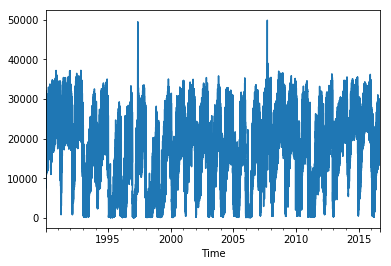

<IPython.core.display.Javascript object>


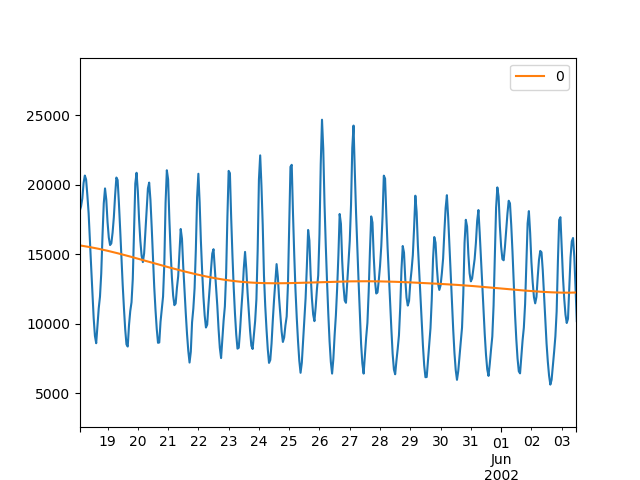

In [199]:
%matplotlib notebook
ax=mtzec.plot()
mtzecg.plot(ax=ax)

In [197]:
#stime=a['start_time'].astype(str)[0]

#stime=pd.to_datetime(a['start_time'].astype(str)[0])
#interval=pd.to_timedelta(a['interval'].astype(str)[0])
#print(stime+)
mtzecg.index=mtzec.index
#pd.DatetimeIndex(data=pd.date_range(start=a['start_time'].astype(str)[0],freq=a['interval'].astype(str)[0],periods=eca.shape[0]),name="Time")
#mtzecg.index=pd.DatetimeIndex(data=pd.date_range(start=a['start_time'].astype(str)[0],freq=a['interval'].astype(str)[0],periods=eca.shape[0]),name="Time")

In [174]:
print(mtzec.size-mtzecg.size)

-288


<IPython.core.display.Javascript object>


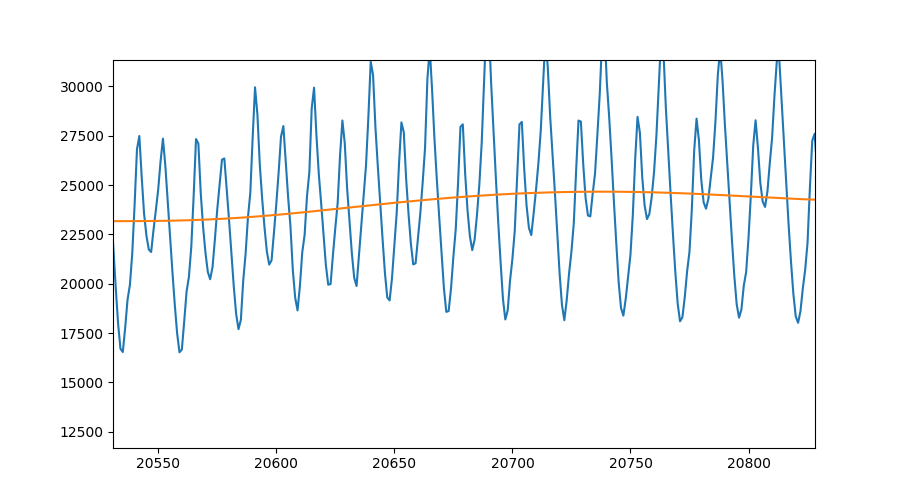

In [191]:
x=mtzec.values
xg=mtzecg.values.reshape(mtzecg.size)
%matplotlib notebook
plt.plot(x)
plt.plot(xg[144:-144])